### Library 

In [4]:
import sys
import os
import datetime
import time
import pandas as pd
import numpy as np
import pickle
from matplotlib import pyplot as plt
import seaborn as sn
from scipy import stats

from keras import backend as K
from keras.callbacks import TensorBoard

path_main_folder = '/home/antorosi/Documents/AutoEncoder'

sys.path.append(path_main_folder)

from CVAE.cvae import compile_cvae, run_cvae
from CVAE.cvae_model import CVAE_temp
from conso.load_shape_data import *  
from conso.conso_helpers import plot_latent_space_projection, pyplot_latent_space_projection_temp, pyplot_latent_space_projection_error
from sklearn.manifold import TSNE

### Load and shape data 

In [5]:
# Load raw data
path_data = os.path.join(path_main_folder, 'data')
dict_data_conso = load_data_conso(path_data)

In [6]:
# Load Holiday day information
holiday_days_csv = os.path.join(path_data, "joursFeries.csv")
holiday_days_df = pd.read_csv(holiday_days_csv, sep=";")
holiday_days_df.ds = pd.to_datetime(holiday_days_df.ds)
holiday_days_df['is_hd'] = 1

In [7]:
# Unifomization
data_conso_df, dict_colnames_conso = get_uniformed_data_conso(dict_data_conso)

In [8]:
# Change ganularity ?
name_granu = '30m'
data_conso_df = change_granularity(data_conso_df, granularity="30min")

In [9]:
# Get x_conso dataframe for autoencoder purpose
x_conso = get_x_conso_autoencoder(data_conso_df, dict_colnames_conso)

### Build dataset 

In [10]:
# Split train and test
date_test_start = datetime.date(2017,1,1)
date_test_end = datetime.date(2017,12,31)
dict_xconso = get_train_test_x_conso(x_conso, date_test_start, date_test_end)


In [11]:
# Normalize x_conso
type_scaler = 's'
dict_xconso, _ = normalize_xconso(dict_xconso, dict_colnames_conso, type_scaler = 'standard')

In [12]:
name_type_cond = 'm-wd-temp'
name_train = '1234' # 1: first period ; 0 all periods
name_type_x = 'c'
type_x = ['conso']
type_cond = ['month', 'weekday', 'temperature']

In [13]:
dataset = get_dataset_autoencoder(dict_xconso=dict_xconso, type_x=type_x, type_cond=type_cond)

In [14]:
# modify dataset to fit with new data format
for type_set in ['train', 'test']:
    
    cond_pre = dataset[type_set]['x'][1][:,:14]
    to_emb = dataset[type_set]['x'][1][:,14:]
    x = dataset[type_set]['x'][0]

    dataset[type_set]['x'] = [x, cond_pre, to_emb]

In [15]:
dataset['test']['x'][2].shape

(365, 48)

### Benchmark parameters

In [16]:
path_out = os.path.join(path_main_folder, 'out')

In [22]:
# Parameters
e_dims=[24,12]
d_dims=[12,24]
emb_dims=[2]
cond_pre_dim = dataset['train']['x'][1].shape[1]
input_dim = dataset['train']['x'][0].shape[1]
to_emb_dim = dataset['train']['x'][2].shape[1]
z_dims = list(np.arange(1,13))
beta = 0
batch_size = 20

In [23]:
path_benchmark = os.path.join(path_out,'benchmark_cae_1')

if not os.path.exists(path_benchmark):
    os.mkdir(path_benchmark)

In [24]:
with open(os.path.join(path_benchmark,"config.txt"),'w') as file: 
    file.write('cond pred dim : ' + str(cond_pre_dim) + '\n')
    file.write('emb_dims : ' + str(emb_dims) + '\n')
    file.write('e_dims : ' + str(e_dims) + '\n') 
    file.write('d_dims : ' + str(d_dims) + '\n') 
    file.write('train_set : ' + str(name_train) + '\n') 
    

In [25]:
results_df = pd.DataFrame(columns=['name', 'z_dim','emb_dims','layer_dims','batchsize','best_iter',
                                           'train_mse', 'test_mse', 'last_train_mse', 'last_test_mse'])
path_results = path_benchmark

========================= Model1=========================
complete model: 
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
to_emb (InputLayer)             (None, 48)           0                                            
__________________________________________________________________________________________________
cond_pre (InputLayer)           (None, 14)           0                                            
__________________________________________________________________________________________________
embedding (Model)               (None, 2)            98          to_emb[0][0]                     
__________________________________________________________________________________________________
x_true (InputLayer)             (None, 48)           0                                            
__________________________________

1465/1465 [==============================] - 0s 67us/step - loss: 1.0216 - kl_loss: 91.9087 - recon_loss: 1.0216 - val_loss: 0.9600 - val_kl_loss: 110.3403 - val_recon_loss: 0.9600
Epoch 8/200
1465/1465 [==============================] - 0s 74us/step - loss: 0.9232 - kl_loss: 91.9167 - recon_loss: 0.9232 - val_loss: 0.9434 - val_kl_loss: 117.1712 - val_recon_loss: 0.9434
Epoch 9/200
1465/1465 [==============================] - 0s 72us/step - loss: 0.8733 - kl_loss: 92.1265 - recon_loss: 0.8733 - val_loss: 0.8033 - val_kl_loss: 108.6713 - val_recon_loss: 0.8033
Epoch 10/200
1465/1465 [==============================] - 0s 70us/step - loss: 0.8236 - kl_loss: 90.9472 - recon_loss: 0.8236 - val_loss: 0.8660 - val_kl_loss: 110.8176 - val_recon_loss: 0.8660
Epoch 11/200
1465/1465 [==============================] - 0s 68us/step - loss: 0.7893 - kl_loss: 89.3433 - recon_loss: 0.7893 - val_loss: 0.8551 - val_kl_loss: 112.8303 - val_recon_loss: 0.8551
Epoch 12/200
1465/1465 [=====================

1465/1465 [==============================] - 0s 70us/step - loss: 0.4626 - kl_loss: 55.1827 - recon_loss: 0.4626 - val_loss: 0.4785 - val_kl_loss: 68.3391 - val_recon_loss: 0.4785
Epoch 50/200
1465/1465 [==============================] - 0s 67us/step - loss: 0.4560 - kl_loss: 54.7904 - recon_loss: 0.4560 - val_loss: 0.5122 - val_kl_loss: 63.9769 - val_recon_loss: 0.5122
Epoch 51/200
1465/1465 [==============================] - 0s 68us/step - loss: 0.4547 - kl_loss: 53.7321 - recon_loss: 0.4547 - val_loss: 0.5229 - val_kl_loss: 67.5081 - val_recon_loss: 0.5229
Epoch 52/200
1465/1465 [==============================] - 0s 64us/step - loss: 0.4582 - kl_loss: 53.7492 - recon_loss: 0.4582 - val_loss: 0.6101 - val_kl_loss: 64.4054 - val_recon_loss: 0.6101
Epoch 53/200
1465/1465 [==============================] - 0s 68us/step - loss: 0.4442 - kl_loss: 54.0641 - recon_loss: 0.4442 - val_loss: 0.5840 - val_kl_loss: 63.0942 - val_recon_loss: 0.5840
Epoch 54/200
1465/1465 [========================

1465/1465 [==============================] - 0s 69us/step - loss: 0.3522 - kl_loss: 44.8020 - recon_loss: 0.3522 - val_loss: 0.3795 - val_kl_loss: 53.5499 - val_recon_loss: 0.3795
Epoch 92/200
1465/1465 [==============================] - 0s 73us/step - loss: 0.3518 - kl_loss: 43.9439 - recon_loss: 0.3518 - val_loss: 0.4353 - val_kl_loss: 51.6222 - val_recon_loss: 0.4353
Epoch 93/200
1465/1465 [==============================] - 0s 72us/step - loss: 0.3545 - kl_loss: 43.8617 - recon_loss: 0.3545 - val_loss: 0.3823 - val_kl_loss: 51.5045 - val_recon_loss: 0.3823
Epoch 94/200
1465/1465 [==============================] - 0s 70us/step - loss: 0.3478 - kl_loss: 43.4110 - recon_loss: 0.3478 - val_loss: 0.3324 - val_kl_loss: 51.5841 - val_recon_loss: 0.3324
Epoch 95/200
1465/1465 [==============================] - 0s 68us/step - loss: 0.3469 - kl_loss: 43.7640 - recon_loss: 0.3469 - val_loss: 0.3249 - val_kl_loss: 51.2701 - val_recon_loss: 0.3249
Epoch 96/200
1465/1465 [========================

1465/1465 [==============================] - 0s 66us/step - loss: 0.3227 - kl_loss: 36.2067 - recon_loss: 0.3227 - val_loss: 0.3533 - val_kl_loss: 41.8547 - val_recon_loss: 0.3533
Epoch 134/200
1465/1465 [==============================] - 0s 69us/step - loss: 0.3187 - kl_loss: 36.1573 - recon_loss: 0.3187 - val_loss: 0.3419 - val_kl_loss: 41.9017 - val_recon_loss: 0.3419
Epoch 135/200
1465/1465 [==============================] - 0s 73us/step - loss: 0.3203 - kl_loss: 36.0552 - recon_loss: 0.3203 - val_loss: 0.3495 - val_kl_loss: 43.2809 - val_recon_loss: 0.3495
Epoch 136/200
1465/1465 [==============================] - 0s 71us/step - loss: 0.3182 - kl_loss: 36.1405 - recon_loss: 0.3182 - val_loss: 0.3627 - val_kl_loss: 42.3379 - val_recon_loss: 0.3627
Epoch 137/200
1465/1465 [==============================] - 0s 71us/step - loss: 0.3164 - kl_loss: 36.2364 - recon_loss: 0.3164 - val_loss: 0.3377 - val_kl_loss: 42.2565 - val_recon_loss: 0.3377
Epoch 138/200
1465/1465 [===================

1465/1465 [==============================] - 0s 71us/step - loss: 0.3011 - kl_loss: 33.5722 - recon_loss: 0.3011 - val_loss: 0.3070 - val_kl_loss: 39.1207 - val_recon_loss: 0.3070
Epoch 176/200
1465/1465 [==============================] - 0s 69us/step - loss: 0.3029 - kl_loss: 33.8316 - recon_loss: 0.3029 - val_loss: 0.2719 - val_kl_loss: 38.8722 - val_recon_loss: 0.2719
Epoch 177/200
1465/1465 [==============================] - 0s 72us/step - loss: 0.3039 - kl_loss: 33.7406 - recon_loss: 0.3039 - val_loss: 0.4506 - val_kl_loss: 36.5449 - val_recon_loss: 0.4506
Epoch 178/200
1465/1465 [==============================] - 0s 71us/step - loss: 0.2980 - kl_loss: 33.3379 - recon_loss: 0.2980 - val_loss: 0.3759 - val_kl_loss: 40.0920 - val_recon_loss: 0.3759
Epoch 179/200
1465/1465 [==============================] - 0s 71us/step - loss: 0.3027 - kl_loss: 33.4642 - recon_loss: 0.3027 - val_loss: 0.4078 - val_kl_loss: 37.9886 - val_recon_loss: 0.4078
Epoch 180/200
1465/1465 [===================

Train on 1465 samples, validate on 365 samples
Epoch 1/200
1465/1465 [==============================] - 0s 132us/step - loss: 38.5154 - kl_loss: 1.3477 - recon_loss: 38.5154 - val_loss: 33.7733 - val_kl_loss: 2.5526 - val_recon_loss: 33.7733
Epoch 2/200
1465/1465 [==============================] - 0s 86us/step - loss: 18.4056 - kl_loss: 8.1304 - recon_loss: 18.4056 - val_loss: 9.3867 - val_kl_loss: 18.3196 - val_recon_loss: 9.3867
Epoch 3/200
1465/1465 [==============================] - 0s 72us/step - loss: 4.3619 - kl_loss: 22.2742 - recon_loss: 4.3619 - val_loss: 2.2373 - val_kl_loss: 30.3304 - val_recon_loss: 2.2373
Epoch 4/200
1465/1465 [==============================] - 0s 69us/step - loss: 1.8219 - kl_loss: 28.7643 - recon_loss: 1.8219 - val_loss: 1.6372 - val_kl_loss: 32.0982 - val_recon_loss: 1.6372
Epoch 5/200
1465/1465 [==============================] - 0s 70us/step - loss: 1.2927 - kl_loss: 31.5512 - recon_loss: 1.2927 - val_loss: 1.1563 - val_kl_loss: 35.6580 - val_recon_lo

1465/1465 [==============================] - 0s 65us/step - loss: 0.2723 - kl_loss: 48.3395 - recon_loss: 0.2723 - val_loss: 0.2867 - val_kl_loss: 51.5414 - val_recon_loss: 0.2867
Epoch 44/200
1465/1465 [==============================] - 0s 66us/step - loss: 0.2641 - kl_loss: 48.2925 - recon_loss: 0.2641 - val_loss: 0.2688 - val_kl_loss: 51.6015 - val_recon_loss: 0.2688
Epoch 45/200
1465/1465 [==============================] - 0s 68us/step - loss: 0.2721 - kl_loss: 48.3593 - recon_loss: 0.2721 - val_loss: 0.2510 - val_kl_loss: 51.4022 - val_recon_loss: 0.2510
Epoch 46/200
1465/1465 [==============================] - 0s 69us/step - loss: 0.2633 - kl_loss: 48.3491 - recon_loss: 0.2633 - val_loss: 0.4192 - val_kl_loss: 51.4569 - val_recon_loss: 0.4192
Epoch 47/200
1465/1465 [==============================] - 0s 74us/step - loss: 0.2641 - kl_loss: 48.4910 - recon_loss: 0.2641 - val_loss: 0.2321 - val_kl_loss: 51.1007 - val_recon_loss: 0.2321
Epoch 48/200
1465/1465 [========================

1465/1465 [==============================] - 0s 69us/step - loss: 0.2097 - kl_loss: 46.6560 - recon_loss: 0.2097 - val_loss: 0.3856 - val_kl_loss: 49.3852 - val_recon_loss: 0.3856
Epoch 86/200
1465/1465 [==============================] - 0s 71us/step - loss: 0.2057 - kl_loss: 46.3347 - recon_loss: 0.2057 - val_loss: 0.2116 - val_kl_loss: 49.2185 - val_recon_loss: 0.2116
Epoch 87/200
1465/1465 [==============================] - 0s 70us/step - loss: 0.2062 - kl_loss: 46.2834 - recon_loss: 0.2062 - val_loss: 0.2462 - val_kl_loss: 48.9459 - val_recon_loss: 0.2462
Epoch 88/200
1465/1465 [==============================] - 0s 68us/step - loss: 0.2075 - kl_loss: 46.3167 - recon_loss: 0.2075 - val_loss: 0.2378 - val_kl_loss: 49.0011 - val_recon_loss: 0.2378
Epoch 89/200
1465/1465 [==============================] - 0s 74us/step - loss: 0.2084 - kl_loss: 46.4156 - recon_loss: 0.2084 - val_loss: 0.2576 - val_kl_loss: 50.2507 - val_recon_loss: 0.2576
Epoch 90/200
1465/1465 [========================

1465/1465 [==============================] - 0s 68us/step - loss: 0.1816 - kl_loss: 46.3604 - recon_loss: 0.1816 - val_loss: 0.3992 - val_kl_loss: 49.6768 - val_recon_loss: 0.3992
Epoch 128/200
1465/1465 [==============================] - 0s 72us/step - loss: 0.1860 - kl_loss: 46.4700 - recon_loss: 0.1860 - val_loss: 0.2243 - val_kl_loss: 48.2522 - val_recon_loss: 0.2243
Epoch 129/200
1465/1465 [==============================] - 0s 71us/step - loss: 0.1790 - kl_loss: 46.4733 - recon_loss: 0.1790 - val_loss: 0.4223 - val_kl_loss: 49.3813 - val_recon_loss: 0.4223
Epoch 130/200
1465/1465 [==============================] - 0s 72us/step - loss: 0.1782 - kl_loss: 46.6274 - recon_loss: 0.1782 - val_loss: 0.1804 - val_kl_loss: 48.9506 - val_recon_loss: 0.1804
Epoch 131/200
1465/1465 [==============================] - 0s 69us/step - loss: 0.1847 - kl_loss: 46.4351 - recon_loss: 0.1847 - val_loss: 0.1861 - val_kl_loss: 48.7064 - val_recon_loss: 0.1861
Epoch 132/200
1465/1465 [===================

1465/1465 [==============================] - 0s 69us/step - loss: 0.1737 - kl_loss: 45.2638 - recon_loss: 0.1737 - val_loss: 0.2110 - val_kl_loss: 47.5958 - val_recon_loss: 0.2110
Epoch 170/200
1465/1465 [==============================] - 0s 77us/step - loss: 0.1712 - kl_loss: 45.2411 - recon_loss: 0.1712 - val_loss: 0.1800 - val_kl_loss: 47.7004 - val_recon_loss: 0.1800
Epoch 171/200
1465/1465 [==============================] - 0s 73us/step - loss: 0.1720 - kl_loss: 45.2206 - recon_loss: 0.1720 - val_loss: 0.1677 - val_kl_loss: 47.0186 - val_recon_loss: 0.1677
Epoch 172/200
1465/1465 [==============================] - 0s 72us/step - loss: 0.1723 - kl_loss: 44.9684 - recon_loss: 0.1723 - val_loss: 0.2391 - val_kl_loss: 47.7334 - val_recon_loss: 0.2391
Epoch 173/200
1465/1465 [==============================] - 0s 73us/step - loss: 0.1706 - kl_loss: 45.0641 - recon_loss: 0.1706 - val_loss: 0.2151 - val_kl_loss: 46.6272 - val_recon_loss: 0.2151
Epoch 174/200
1465/1465 [===================

Train on 1465 samples, validate on 365 samples
Epoch 1/200
1465/1465 [==============================] - 0s 137us/step - loss: 29.1590 - kl_loss: 17.4094 - recon_loss: 29.1590 - val_loss: 10.2439 - val_kl_loss: 40.3556 - val_recon_loss: 10.2439
Epoch 2/200
1465/1465 [==============================] - 0s 79us/step - loss: 4.1447 - kl_loss: 46.5573 - recon_loss: 4.1447 - val_loss: 2.1761 - val_kl_loss: 60.0836 - val_recon_loss: 2.1761
Epoch 3/200
1465/1465 [==============================] - 0s 73us/step - loss: 1.9046 - kl_loss: 56.9918 - recon_loss: 1.9046 - val_loss: 1.5612 - val_kl_loss: 67.3384 - val_recon_loss: 1.5612
Epoch 4/200
1465/1465 [==============================] - 0s 74us/step - loss: 1.3543 - kl_loss: 60.2437 - recon_loss: 1.3543 - val_loss: 1.1411 - val_kl_loss: 70.2040 - val_recon_loss: 1.1411
Epoch 5/200
1465/1465 [==============================] - 0s 77us/step - loss: 1.0729 - kl_loss: 61.5938 - recon_loss: 1.0729 - val_loss: 0.9207 - val_kl_loss: 68.4178 - val_recon_l

1465/1465 [==============================] - 0s 69us/step - loss: 0.2471 - kl_loss: 65.5460 - recon_loss: 0.2471 - val_loss: 0.2801 - val_kl_loss: 71.7076 - val_recon_loss: 0.2801
Epoch 44/200
1465/1465 [==============================] - 0s 70us/step - loss: 0.2429 - kl_loss: 64.9744 - recon_loss: 0.2429 - val_loss: 0.2738 - val_kl_loss: 70.7012 - val_recon_loss: 0.2738
Epoch 45/200
1465/1465 [==============================] - 0s 70us/step - loss: 0.2414 - kl_loss: 64.7342 - recon_loss: 0.2414 - val_loss: 0.4290 - val_kl_loss: 72.1935 - val_recon_loss: 0.4290
Epoch 46/200
1465/1465 [==============================] - 0s 65us/step - loss: 0.2410 - kl_loss: 64.4098 - recon_loss: 0.2410 - val_loss: 0.2525 - val_kl_loss: 70.7910 - val_recon_loss: 0.2525
Epoch 47/200
1465/1465 [==============================] - 0s 70us/step - loss: 0.2355 - kl_loss: 64.3443 - recon_loss: 0.2355 - val_loss: 0.2080 - val_kl_loss: 69.9731 - val_recon_loss: 0.2080
Epoch 48/200
1465/1465 [========================

1465/1465 [==============================] - 0s 69us/step - loss: 0.1594 - kl_loss: 64.0075 - recon_loss: 0.1594 - val_loss: 0.1546 - val_kl_loss: 69.0839 - val_recon_loss: 0.1546
Epoch 86/200
1465/1465 [==============================] - 0s 72us/step - loss: 0.1580 - kl_loss: 64.0695 - recon_loss: 0.1580 - val_loss: 0.1313 - val_kl_loss: 68.6516 - val_recon_loss: 0.1313
Epoch 87/200
1465/1465 [==============================] - 0s 70us/step - loss: 0.1585 - kl_loss: 64.1801 - recon_loss: 0.1585 - val_loss: 0.3383 - val_kl_loss: 66.9435 - val_recon_loss: 0.3383
Epoch 88/200
1465/1465 [==============================] - 0s 69us/step - loss: 0.1508 - kl_loss: 64.1306 - recon_loss: 0.1508 - val_loss: 0.1803 - val_kl_loss: 68.8488 - val_recon_loss: 0.1803
Epoch 89/200
1465/1465 [==============================] - 0s 69us/step - loss: 0.1559 - kl_loss: 64.2480 - recon_loss: 0.1559 - val_loss: 0.2397 - val_kl_loss: 70.3782 - val_recon_loss: 0.2397
Epoch 90/200
1465/1465 [========================

1465/1465 [==============================] - 0s 65us/step - loss: 0.1319 - kl_loss: 63.6652 - recon_loss: 0.1319 - val_loss: 0.1927 - val_kl_loss: 67.1014 - val_recon_loss: 0.1927
Epoch 128/200
1465/1465 [==============================] - 0s 69us/step - loss: 0.1342 - kl_loss: 63.5587 - recon_loss: 0.1342 - val_loss: 0.1073 - val_kl_loss: 67.9048 - val_recon_loss: 0.1073
Epoch 129/200
1465/1465 [==============================] - 0s 70us/step - loss: 0.1340 - kl_loss: 63.7154 - recon_loss: 0.1340 - val_loss: 0.1345 - val_kl_loss: 69.2303 - val_recon_loss: 0.1345
Epoch 130/200
1465/1465 [==============================] - 0s 69us/step - loss: 0.1311 - kl_loss: 64.1508 - recon_loss: 0.1311 - val_loss: 0.1195 - val_kl_loss: 68.8128 - val_recon_loss: 0.1195
Epoch 131/200
1465/1465 [==============================] - 0s 72us/step - loss: 0.1341 - kl_loss: 64.2332 - recon_loss: 0.1341 - val_loss: 0.2500 - val_kl_loss: 67.9330 - val_recon_loss: 0.2500
Epoch 132/200
1465/1465 [===================

1465/1465 [==============================] - 0s 65us/step - loss: 0.1181 - kl_loss: 64.2500 - recon_loss: 0.1181 - val_loss: 0.1493 - val_kl_loss: 68.8568 - val_recon_loss: 0.1493
Epoch 170/200
1465/1465 [==============================] - 0s 66us/step - loss: 0.1168 - kl_loss: 64.1841 - recon_loss: 0.1168 - val_loss: 0.1682 - val_kl_loss: 67.9023 - val_recon_loss: 0.1682
Epoch 171/200
1465/1465 [==============================] - 0s 65us/step - loss: 0.1184 - kl_loss: 64.3104 - recon_loss: 0.1184 - val_loss: 0.1781 - val_kl_loss: 69.4009 - val_recon_loss: 0.1781
Epoch 172/200
1465/1465 [==============================] - 0s 73us/step - loss: 0.1262 - kl_loss: 64.4321 - recon_loss: 0.1262 - val_loss: 0.2066 - val_kl_loss: 67.2684 - val_recon_loss: 0.2066
Epoch 173/200
1465/1465 [==============================] - 0s 70us/step - loss: 0.1162 - kl_loss: 64.5050 - recon_loss: 0.1162 - val_loss: 0.1597 - val_kl_loss: 69.5705 - val_recon_loss: 0.1597
Epoch 174/200
1465/1465 [===================

Train on 1465 samples, validate on 365 samples
Epoch 1/200
1465/1465 [==============================] - 0s 127us/step - loss: 33.4124 - kl_loss: 9.1807 - recon_loss: 33.4124 - val_loss: 15.9500 - val_kl_loss: 25.0049 - val_recon_loss: 15.9500
Epoch 2/200
1465/1465 [==============================] - 0s 74us/step - loss: 7.8377 - kl_loss: 34.6681 - recon_loss: 7.8377 - val_loss: 4.1196 - val_kl_loss: 51.7134 - val_recon_loss: 4.1196
Epoch 3/200
1465/1465 [==============================] - 0s 70us/step - loss: 2.6208 - kl_loss: 54.1228 - recon_loss: 2.6208 - val_loss: 1.7205 - val_kl_loss: 69.7935 - val_recon_loss: 1.7205
Epoch 4/200
1465/1465 [==============================] - 0s 69us/step - loss: 1.4129 - kl_loss: 68.7581 - recon_loss: 1.4129 - val_loss: 1.2006 - val_kl_loss: 82.8510 - val_recon_loss: 1.2006
Epoch 5/200
1465/1465 [==============================] - 0s 75us/step - loss: 1.0584 - kl_loss: 81.7238 - recon_loss: 1.0584 - val_loss: 1.0704 - val_kl_loss: 92.4927 - val_recon_lo

Epoch 43/200
1465/1465 [==============================] - 0s 66us/step - loss: 0.2337 - kl_loss: 102.2250 - recon_loss: 0.2337 - val_loss: 0.2493 - val_kl_loss: 109.0251 - val_recon_loss: 0.2493
Epoch 44/200
1465/1465 [==============================] - 0s 69us/step - loss: 0.2260 - kl_loss: 101.5950 - recon_loss: 0.2260 - val_loss: 0.2365 - val_kl_loss: 107.7117 - val_recon_loss: 0.2365
Epoch 45/200
1465/1465 [==============================] - 0s 66us/step - loss: 0.2272 - kl_loss: 101.4009 - recon_loss: 0.2272 - val_loss: 0.2242 - val_kl_loss: 108.1437 - val_recon_loss: 0.2242
Epoch 46/200
1465/1465 [==============================] - 0s 79us/step - loss: 0.2223 - kl_loss: 101.3963 - recon_loss: 0.2223 - val_loss: 0.2281 - val_kl_loss: 108.0296 - val_recon_loss: 0.2281
Epoch 47/200
1465/1465 [==============================] - 0s 71us/step - loss: 0.2223 - kl_loss: 101.3861 - recon_loss: 0.2223 - val_loss: 0.5262 - val_kl_loss: 105.4014 - val_recon_loss: 0.5262
Epoch 48/200
1465/1465 [=

1465/1465 [==============================] - 0s 71us/step - loss: 0.1444 - kl_loss: 98.6412 - recon_loss: 0.1444 - val_loss: 0.1274 - val_kl_loss: 105.0728 - val_recon_loss: 0.1274
Epoch 86/200
1465/1465 [==============================] - 0s 78us/step - loss: 0.1466 - kl_loss: 98.7324 - recon_loss: 0.1466 - val_loss: 0.2729 - val_kl_loss: 107.0547 - val_recon_loss: 0.2729
Epoch 87/200
1465/1465 [==============================] - 0s 70us/step - loss: 0.1478 - kl_loss: 99.0255 - recon_loss: 0.1478 - val_loss: 0.2308 - val_kl_loss: 107.4142 - val_recon_loss: 0.2308
Epoch 88/200
1465/1465 [==============================] - 0s 73us/step - loss: 0.1474 - kl_loss: 99.0734 - recon_loss: 0.1474 - val_loss: 0.1521 - val_kl_loss: 105.2492 - val_recon_loss: 0.1521
Epoch 89/200
1465/1465 [==============================] - 0s 71us/step - loss: 0.1442 - kl_loss: 98.8465 - recon_loss: 0.1442 - val_loss: 0.3925 - val_kl_loss: 103.9228 - val_recon_loss: 0.3925
Epoch 90/200
1465/1465 [===================

1465/1465 [==============================] - 0s 73us/step - loss: 0.1171 - kl_loss: 98.5617 - recon_loss: 0.1171 - val_loss: 0.2691 - val_kl_loss: 101.3952 - val_recon_loss: 0.2691
Epoch 128/200
1465/1465 [==============================] - 0s 71us/step - loss: 0.1193 - kl_loss: 98.3939 - recon_loss: 0.1193 - val_loss: 0.1554 - val_kl_loss: 105.2293 - val_recon_loss: 0.1554
Epoch 129/200
1465/1465 [==============================] - 0s 74us/step - loss: 0.1195 - kl_loss: 98.3093 - recon_loss: 0.1195 - val_loss: 0.1144 - val_kl_loss: 103.5429 - val_recon_loss: 0.1144
Epoch 130/200
1465/1465 [==============================] - 0s 71us/step - loss: 0.1172 - kl_loss: 98.0407 - recon_loss: 0.1172 - val_loss: 0.1240 - val_kl_loss: 103.4687 - val_recon_loss: 0.1240
Epoch 131/200
1465/1465 [==============================] - 0s 67us/step - loss: 0.1187 - kl_loss: 97.6953 - recon_loss: 0.1187 - val_loss: 0.1568 - val_kl_loss: 103.3851 - val_recon_loss: 0.1568
Epoch 132/200
1465/1465 [==============

1465/1465 [==============================] - 0s 68us/step - loss: 0.1084 - kl_loss: 99.0332 - recon_loss: 0.1084 - val_loss: 0.0948 - val_kl_loss: 104.6057 - val_recon_loss: 0.0948
Epoch 170/200
1465/1465 [==============================] - 0s 73us/step - loss: 0.1026 - kl_loss: 98.9653 - recon_loss: 0.1026 - val_loss: 0.2452 - val_kl_loss: 105.7464 - val_recon_loss: 0.2452
Epoch 171/200
1465/1465 [==============================] - 0s 67us/step - loss: 0.1079 - kl_loss: 98.5520 - recon_loss: 0.1079 - val_loss: 0.1954 - val_kl_loss: 103.7799 - val_recon_loss: 0.1954
Epoch 172/200
1465/1465 [==============================] - 0s 66us/step - loss: 0.1079 - kl_loss: 98.3014 - recon_loss: 0.1079 - val_loss: 0.1201 - val_kl_loss: 104.6762 - val_recon_loss: 0.1201
Epoch 173/200
1465/1465 [==============================] - 0s 68us/step - loss: 0.1069 - kl_loss: 98.4760 - recon_loss: 0.1069 - val_loss: 0.1279 - val_kl_loss: 103.2456 - val_recon_loss: 0.1279
Epoch 174/200
1465/1465 [==============

Train on 1465 samples, validate on 365 samples
Epoch 1/200
1465/1465 [==============================] - 0s 156us/step - loss: 31.5968 - kl_loss: 13.1149 - recon_loss: 31.5968 - val_loss: 13.5897 - val_kl_loss: 33.9761 - val_recon_loss: 13.5897
Epoch 2/200
1465/1465 [==============================] - 0s 79us/step - loss: 5.7435 - kl_loss: 38.9775 - recon_loss: 5.7435 - val_loss: 2.7508 - val_kl_loss: 49.0083 - val_recon_loss: 2.7508
Epoch 3/200
1465/1465 [==============================] - 0s 74us/step - loss: 1.9118 - kl_loss: 49.7173 - recon_loss: 1.9118 - val_loss: 1.5170 - val_kl_loss: 61.2423 - val_recon_loss: 1.5170
Epoch 4/200
1465/1465 [==============================] - 0s 71us/step - loss: 1.2455 - kl_loss: 56.8907 - recon_loss: 1.2455 - val_loss: 1.0239 - val_kl_loss: 67.0189 - val_recon_loss: 1.0239
Epoch 5/200
1465/1465 [==============================] - 0s 63us/step - loss: 0.9484 - kl_loss: 62.9909 - recon_loss: 0.9484 - val_loss: 0.9097 - val_kl_loss: 71.5011 - val_recon_l

1465/1465 [==============================] - 0s 78us/step - loss: 0.2023 - kl_loss: 87.1084 - recon_loss: 0.2023 - val_loss: 0.3751 - val_kl_loss: 94.0348 - val_recon_loss: 0.3751
Epoch 44/200
1465/1465 [==============================] - 0s 78us/step - loss: 0.2053 - kl_loss: 87.1022 - recon_loss: 0.2053 - val_loss: 0.2263 - val_kl_loss: 93.3906 - val_recon_loss: 0.2263
Epoch 45/200
1465/1465 [==============================] - 0s 76us/step - loss: 0.1997 - kl_loss: 86.9621 - recon_loss: 0.1997 - val_loss: 0.2517 - val_kl_loss: 93.9613 - val_recon_loss: 0.2517
Epoch 46/200
1465/1465 [==============================] - 0s 80us/step - loss: 0.1985 - kl_loss: 86.7938 - recon_loss: 0.1985 - val_loss: 0.1983 - val_kl_loss: 92.3810 - val_recon_loss: 0.1983
Epoch 47/200
1465/1465 [==============================] - 0s 79us/step - loss: 0.1974 - kl_loss: 86.9606 - recon_loss: 0.1974 - val_loss: 0.2014 - val_kl_loss: 92.4693 - val_recon_loss: 0.2014
Epoch 48/200
1465/1465 [========================

1465/1465 [==============================] - 0s 75us/step - loss: 0.1388 - kl_loss: 85.7922 - recon_loss: 0.1388 - val_loss: 0.1492 - val_kl_loss: 91.2771 - val_recon_loss: 0.1492
Epoch 86/200
1465/1465 [==============================] - 0s 75us/step - loss: 0.1326 - kl_loss: 85.6688 - recon_loss: 0.1326 - val_loss: 0.1313 - val_kl_loss: 90.4355 - val_recon_loss: 0.1313
Epoch 87/200
1465/1465 [==============================] - 0s 84us/step - loss: 0.1418 - kl_loss: 85.6114 - recon_loss: 0.1418 - val_loss: 0.1155 - val_kl_loss: 91.1540 - val_recon_loss: 0.1155
Epoch 88/200
1465/1465 [==============================] - 0s 69us/step - loss: 0.1307 - kl_loss: 85.7031 - recon_loss: 0.1307 - val_loss: 0.1323 - val_kl_loss: 90.8710 - val_recon_loss: 0.1323
Epoch 89/200
1465/1465 [==============================] - 0s 76us/step - loss: 0.1337 - kl_loss: 85.9397 - recon_loss: 0.1337 - val_loss: 0.1380 - val_kl_loss: 90.4723 - val_recon_loss: 0.1380
Epoch 90/200
1465/1465 [========================

1465/1465 [==============================] - 0s 77us/step - loss: 0.1174 - kl_loss: 85.1041 - recon_loss: 0.1174 - val_loss: 0.2369 - val_kl_loss: 88.6037 - val_recon_loss: 0.2369
Epoch 128/200
1465/1465 [==============================] - 0s 80us/step - loss: 0.1160 - kl_loss: 85.1675 - recon_loss: 0.1160 - val_loss: 0.1093 - val_kl_loss: 90.0039 - val_recon_loss: 0.1093
Epoch 129/200
1465/1465 [==============================] - 0s 79us/step - loss: 0.1140 - kl_loss: 85.4726 - recon_loss: 0.1140 - val_loss: 0.1427 - val_kl_loss: 89.2745 - val_recon_loss: 0.1427
Epoch 130/200
1465/1465 [==============================] - 0s 80us/step - loss: 0.1126 - kl_loss: 85.4965 - recon_loss: 0.1126 - val_loss: 0.1282 - val_kl_loss: 90.4891 - val_recon_loss: 0.1282
Epoch 131/200
1465/1465 [==============================] - 0s 83us/step - loss: 0.1155 - kl_loss: 85.6973 - recon_loss: 0.1155 - val_loss: 0.1197 - val_kl_loss: 89.4542 - val_recon_loss: 0.1197
Epoch 132/200
1465/1465 [===================

1465/1465 [==============================] - 0s 70us/step - loss: 0.1032 - kl_loss: 87.3274 - recon_loss: 0.1032 - val_loss: 0.1285 - val_kl_loss: 93.0919 - val_recon_loss: 0.1285
Epoch 170/200
1465/1465 [==============================] - 0s 67us/step - loss: 0.1044 - kl_loss: 87.2414 - recon_loss: 0.1044 - val_loss: 0.1004 - val_kl_loss: 91.7953 - val_recon_loss: 0.1004
Epoch 171/200
1465/1465 [==============================] - 0s 67us/step - loss: 0.1011 - kl_loss: 87.1733 - recon_loss: 0.1011 - val_loss: 0.1389 - val_kl_loss: 90.6690 - val_recon_loss: 0.1389
Epoch 172/200
1465/1465 [==============================] - 0s 67us/step - loss: 0.1075 - kl_loss: 87.0150 - recon_loss: 0.1075 - val_loss: 0.1106 - val_kl_loss: 91.6890 - val_recon_loss: 0.1106
Epoch 173/200
1465/1465 [==============================] - 0s 67us/step - loss: 0.1026 - kl_loss: 87.2424 - recon_loss: 0.1026 - val_loss: 0.0968 - val_kl_loss: 91.6875 - val_recon_loss: 0.0968
Epoch 174/200
1465/1465 [===================

Train on 1465 samples, validate on 365 samples
Epoch 1/200
1465/1465 [==============================] - 0s 140us/step - loss: 24.6298 - kl_loss: 21.7587 - recon_loss: 24.6298 - val_loss: 4.8178 - val_kl_loss: 53.8385 - val_recon_loss: 4.8178
Epoch 2/200
1465/1465 [==============================] - 0s 75us/step - loss: 2.8809 - kl_loss: 61.3263 - recon_loss: 2.8809 - val_loss: 1.8310 - val_kl_loss: 77.6929 - val_recon_loss: 1.8310
Epoch 3/200
1465/1465 [==============================] - 0s 82us/step - loss: 1.4486 - kl_loss: 79.8897 - recon_loss: 1.4486 - val_loss: 1.2201 - val_kl_loss: 87.0345 - val_recon_loss: 1.2201
Epoch 4/200
1465/1465 [==============================] - 0s 76us/step - loss: 1.0273 - kl_loss: 88.9721 - recon_loss: 1.0273 - val_loss: 1.6168 - val_kl_loss: 95.1038 - val_recon_loss: 1.6168
Epoch 5/200
1465/1465 [==============================] - 0s 75us/step - loss: 0.8623 - kl_loss: 95.4533 - recon_loss: 0.8623 - val_loss: 0.8048 - val_kl_loss: 104.9825 - val_recon_lo

Epoch 43/200
1465/1465 [==============================] - 0s 80us/step - loss: 0.1822 - kl_loss: 101.3532 - recon_loss: 0.1822 - val_loss: 0.1525 - val_kl_loss: 104.8578 - val_recon_loss: 0.1525
Epoch 44/200
1465/1465 [==============================] - 0s 71us/step - loss: 0.1861 - kl_loss: 101.2643 - recon_loss: 0.1861 - val_loss: 0.2634 - val_kl_loss: 104.8258 - val_recon_loss: 0.2634
Epoch 45/200
1465/1465 [==============================] - 0s 76us/step - loss: 0.1828 - kl_loss: 101.5072 - recon_loss: 0.1828 - val_loss: 0.6286 - val_kl_loss: 108.4757 - val_recon_loss: 0.6286
Epoch 46/200
1465/1465 [==============================] - 0s 79us/step - loss: 0.1826 - kl_loss: 101.3806 - recon_loss: 0.1826 - val_loss: 0.1422 - val_kl_loss: 106.0369 - val_recon_loss: 0.1422
Epoch 47/200
1465/1465 [==============================] - 0s 87us/step - loss: 0.1866 - kl_loss: 100.9738 - recon_loss: 0.1866 - val_loss: 0.1284 - val_kl_loss: 105.2762 - val_recon_loss: 0.1284
Epoch 48/200
1465/1465 [=

1465/1465 [==============================] - 0s 85us/step - loss: 0.1370 - kl_loss: 99.2886 - recon_loss: 0.1370 - val_loss: 0.3257 - val_kl_loss: 101.9332 - val_recon_loss: 0.3257
Epoch 86/200
1465/1465 [==============================] - 0s 80us/step - loss: 0.1412 - kl_loss: 99.1738 - recon_loss: 0.1412 - val_loss: 0.1396 - val_kl_loss: 102.9426 - val_recon_loss: 0.1396
Epoch 87/200
1465/1465 [==============================] - 0s 73us/step - loss: 0.1417 - kl_loss: 99.5994 - recon_loss: 0.1417 - val_loss: 0.1350 - val_kl_loss: 102.7556 - val_recon_loss: 0.1350
Epoch 88/200
1465/1465 [==============================] - 0s 77us/step - loss: 0.1356 - kl_loss: 99.7125 - recon_loss: 0.1356 - val_loss: 0.2233 - val_kl_loss: 105.7572 - val_recon_loss: 0.2233
Epoch 89/200
1465/1465 [==============================] - 0s 75us/step - loss: 0.1408 - kl_loss: 100.1068 - recon_loss: 0.1408 - val_loss: 0.1106 - val_kl_loss: 103.1201 - val_recon_loss: 0.1106
Epoch 90/200
1465/1465 [==================

1465/1465 [==============================] - 0s 67us/step - loss: 0.1088 - kl_loss: 99.8190 - recon_loss: 0.1088 - val_loss: 0.1505 - val_kl_loss: 103.0616 - val_recon_loss: 0.1505
Epoch 128/200
1465/1465 [==============================] - 0s 67us/step - loss: 0.1135 - kl_loss: 99.5047 - recon_loss: 0.1135 - val_loss: 0.0922 - val_kl_loss: 102.8848 - val_recon_loss: 0.0922
Epoch 129/200
1465/1465 [==============================] - 0s 74us/step - loss: 0.1096 - kl_loss: 99.5755 - recon_loss: 0.1096 - val_loss: 0.2185 - val_kl_loss: 102.3165 - val_recon_loss: 0.2185
Epoch 130/200
1465/1465 [==============================] - 0s 73us/step - loss: 0.1140 - kl_loss: 99.2505 - recon_loss: 0.1140 - val_loss: 0.1507 - val_kl_loss: 101.3859 - val_recon_loss: 0.1507
Epoch 131/200
1465/1465 [==============================] - 0s 75us/step - loss: 0.1110 - kl_loss: 99.1421 - recon_loss: 0.1110 - val_loss: 0.0828 - val_kl_loss: 102.7428 - val_recon_loss: 0.0828
Epoch 132/200
1465/1465 [==============

Epoch 169/200
1465/1465 [==============================] - 0s 70us/step - loss: 0.0976 - kl_loss: 100.1393 - recon_loss: 0.0976 - val_loss: 0.0857 - val_kl_loss: 102.2528 - val_recon_loss: 0.0857
Epoch 170/200
1465/1465 [==============================] - 0s 79us/step - loss: 0.0980 - kl_loss: 99.9452 - recon_loss: 0.0980 - val_loss: 0.1806 - val_kl_loss: 104.8274 - val_recon_loss: 0.1806
Epoch 171/200
1465/1465 [==============================] - 0s 77us/step - loss: 0.1037 - kl_loss: 100.2428 - recon_loss: 0.1037 - val_loss: 0.1570 - val_kl_loss: 101.3676 - val_recon_loss: 0.1570
Epoch 172/200
1465/1465 [==============================] - 0s 81us/step - loss: 0.0974 - kl_loss: 100.1781 - recon_loss: 0.0974 - val_loss: 0.0746 - val_kl_loss: 103.4540 - val_recon_loss: 0.0746
Epoch 173/200
1465/1465 [==============================] - 0s 84us/step - loss: 0.0968 - kl_loss: 100.3130 - recon_loss: 0.0968 - val_loss: 0.2807 - val_kl_loss: 104.0611 - val_recon_loss: 0.2807
Epoch 174/200
1465/14

Train on 1465 samples, validate on 365 samples
Epoch 1/200
1465/1465 [==============================] - 0s 126us/step - loss: 34.1140 - kl_loss: 14.0429 - recon_loss: 34.1140 - val_loss: 15.5431 - val_kl_loss: 37.0860 - val_recon_loss: 15.5431
Epoch 2/200
1465/1465 [==============================] - 0s 69us/step - loss: 6.3653 - kl_loss: 40.7997 - recon_loss: 6.3653 - val_loss: 3.4257 - val_kl_loss: 58.0404 - val_recon_loss: 3.4257
Epoch 3/200
1465/1465 [==============================] - 0s 69us/step - loss: 2.8178 - kl_loss: 51.9276 - recon_loss: 2.8178 - val_loss: 2.4648 - val_kl_loss: 64.7634 - val_recon_loss: 2.4648
Epoch 4/200
1465/1465 [==============================] - 0s 70us/step - loss: 1.9876 - kl_loss: 59.6445 - recon_loss: 1.9876 - val_loss: 1.5655 - val_kl_loss: 71.8127 - val_recon_loss: 1.5655
Epoch 5/200
1465/1465 [==============================] - 0s 76us/step - loss: 1.2899 - kl_loss: 66.0232 - recon_loss: 1.2899 - val_loss: 1.0786 - val_kl_loss: 78.2442 - val_recon_l

1465/1465 [==============================] - 0s 71us/step - loss: 0.1977 - kl_loss: 89.3607 - recon_loss: 0.1977 - val_loss: 0.3428 - val_kl_loss: 94.5502 - val_recon_loss: 0.3428
Epoch 44/200
1465/1465 [==============================] - 0s 74us/step - loss: 0.1930 - kl_loss: 89.3806 - recon_loss: 0.1930 - val_loss: 0.2709 - val_kl_loss: 97.4078 - val_recon_loss: 0.2709
Epoch 45/200
1465/1465 [==============================] - 0s 79us/step - loss: 0.1856 - kl_loss: 89.4257 - recon_loss: 0.1856 - val_loss: 0.2428 - val_kl_loss: 96.8204 - val_recon_loss: 0.2428
Epoch 46/200
1465/1465 [==============================] - 0s 68us/step - loss: 0.1906 - kl_loss: 89.6627 - recon_loss: 0.1906 - val_loss: 0.3303 - val_kl_loss: 94.1256 - val_recon_loss: 0.3303
Epoch 47/200
1465/1465 [==============================] - 0s 69us/step - loss: 0.1862 - kl_loss: 89.7536 - recon_loss: 0.1862 - val_loss: 0.1978 - val_kl_loss: 96.3070 - val_recon_loss: 0.1978
Epoch 48/200
1465/1465 [========================

1465/1465 [==============================] - 0s 74us/step - loss: 0.1319 - kl_loss: 90.1146 - recon_loss: 0.1319 - val_loss: 0.4085 - val_kl_loss: 93.7115 - val_recon_loss: 0.4085
Epoch 86/200
1465/1465 [==============================] - 0s 71us/step - loss: 0.1393 - kl_loss: 90.0716 - recon_loss: 0.1393 - val_loss: 0.1997 - val_kl_loss: 95.5561 - val_recon_loss: 0.1997
Epoch 87/200
1465/1465 [==============================] - 0s 100us/step - loss: 0.1271 - kl_loss: 90.2519 - recon_loss: 0.1271 - val_loss: 0.1774 - val_kl_loss: 93.0294 - val_recon_loss: 0.1774
Epoch 88/200
1465/1465 [==============================] - 0s 77us/step - loss: 0.1311 - kl_loss: 90.3110 - recon_loss: 0.1311 - val_loss: 0.1067 - val_kl_loss: 95.0835 - val_recon_loss: 0.1067
Epoch 89/200
1465/1465 [==============================] - 0s 75us/step - loss: 0.1269 - kl_loss: 90.5849 - recon_loss: 0.1269 - val_loss: 0.1202 - val_kl_loss: 96.1001 - val_recon_loss: 0.1202
Epoch 90/200
1465/1465 [=======================

1465/1465 [==============================] - 0s 77us/step - loss: 0.1020 - kl_loss: 93.4673 - recon_loss: 0.1020 - val_loss: 0.1803 - val_kl_loss: 97.7271 - val_recon_loss: 0.1803
Epoch 128/200
1465/1465 [==============================] - 0s 71us/step - loss: 0.1060 - kl_loss: 93.7972 - recon_loss: 0.1060 - val_loss: 0.0754 - val_kl_loss: 98.5502 - val_recon_loss: 0.0754
Epoch 129/200
1465/1465 [==============================] - 0s 73us/step - loss: 0.1062 - kl_loss: 94.0289 - recon_loss: 0.1062 - val_loss: 0.3237 - val_kl_loss: 98.1166 - val_recon_loss: 0.3237
Epoch 130/200
1465/1465 [==============================] - 0s 80us/step - loss: 0.1035 - kl_loss: 93.9041 - recon_loss: 0.1035 - val_loss: 0.3626 - val_kl_loss: 96.1761 - val_recon_loss: 0.3626
Epoch 131/200
1465/1465 [==============================] - 0s 75us/step - loss: 0.1013 - kl_loss: 93.9128 - recon_loss: 0.1013 - val_loss: 0.1771 - val_kl_loss: 100.3248 - val_recon_loss: 0.1771
Epoch 132/200
1465/1465 [==================

1465/1465 [==============================] - 0s 75us/step - loss: 0.0907 - kl_loss: 95.8303 - recon_loss: 0.0907 - val_loss: 0.1191 - val_kl_loss: 99.9562 - val_recon_loss: 0.1191
Epoch 170/200
1465/1465 [==============================] - 0s 73us/step - loss: 0.0957 - kl_loss: 95.9598 - recon_loss: 0.0957 - val_loss: 0.2185 - val_kl_loss: 101.9173 - val_recon_loss: 0.2185
Epoch 171/200
1465/1465 [==============================] - 0s 76us/step - loss: 0.0922 - kl_loss: 95.9263 - recon_loss: 0.0922 - val_loss: 0.1417 - val_kl_loss: 101.5438 - val_recon_loss: 0.1417
Epoch 172/200
1465/1465 [==============================] - 0s 69us/step - loss: 0.0971 - kl_loss: 95.8253 - recon_loss: 0.0971 - val_loss: 0.0918 - val_kl_loss: 100.0686 - val_recon_loss: 0.0918
Epoch 173/200
1465/1465 [==============================] - 0s 66us/step - loss: 0.0886 - kl_loss: 95.7365 - recon_loss: 0.0886 - val_loss: 0.0788 - val_kl_loss: 98.8960 - val_recon_loss: 0.0788
Epoch 174/200
1465/1465 [================

Train on 1465 samples, validate on 365 samples
Epoch 1/200
1465/1465 [==============================] - 0s 137us/step - loss: 26.4961 - kl_loss: 21.7167 - recon_loss: 26.4961 - val_loss: 7.8925 - val_kl_loss: 51.3525 - val_recon_loss: 7.8925
Epoch 2/200
1465/1465 [==============================] - 0s 70us/step - loss: 4.0853 - kl_loss: 53.3359 - recon_loss: 4.0853 - val_loss: 2.8919 - val_kl_loss: 64.6835 - val_recon_loss: 2.8919
Epoch 3/200
1465/1465 [==============================] - 0s 76us/step - loss: 2.2224 - kl_loss: 61.1844 - recon_loss: 2.2224 - val_loss: 1.5556 - val_kl_loss: 75.2379 - val_recon_loss: 1.5556
Epoch 4/200
1465/1465 [==============================] - 0s 74us/step - loss: 1.3395 - kl_loss: 68.7546 - recon_loss: 1.3395 - val_loss: 1.1504 - val_kl_loss: 78.9175 - val_recon_loss: 1.1504
Epoch 5/200
1465/1465 [==============================] - 0s 80us/step - loss: 1.0186 - kl_loss: 74.4967 - recon_loss: 1.0186 - val_loss: 1.2284 - val_kl_loss: 88.3642 - val_recon_los

Epoch 43/200
1465/1465 [==============================] - 0s 70us/step - loss: 0.1837 - kl_loss: 104.9658 - recon_loss: 0.1837 - val_loss: 0.1528 - val_kl_loss: 111.5298 - val_recon_loss: 0.1528
Epoch 44/200
1465/1465 [==============================] - 0s 75us/step - loss: 0.1843 - kl_loss: 105.1934 - recon_loss: 0.1843 - val_loss: 0.1625 - val_kl_loss: 112.2719 - val_recon_loss: 0.1625
Epoch 45/200
1465/1465 [==============================] - 0s 84us/step - loss: 0.1798 - kl_loss: 105.2920 - recon_loss: 0.1798 - val_loss: 0.5523 - val_kl_loss: 110.4977 - val_recon_loss: 0.5523
Epoch 46/200
1465/1465 [==============================] - 0s 65us/step - loss: 0.1795 - kl_loss: 104.9798 - recon_loss: 0.1795 - val_loss: 0.1857 - val_kl_loss: 112.3763 - val_recon_loss: 0.1857
Epoch 47/200
1465/1465 [==============================] - 0s 70us/step - loss: 0.1716 - kl_loss: 105.4764 - recon_loss: 0.1716 - val_loss: 0.3058 - val_kl_loss: 111.6631 - val_recon_loss: 0.3058
Epoch 48/200
1465/1465 [=

1465/1465 [==============================] - 0s 77us/step - loss: 0.1355 - kl_loss: 105.9288 - recon_loss: 0.1355 - val_loss: 0.1288 - val_kl_loss: 110.3741 - val_recon_loss: 0.1288
Epoch 86/200
1465/1465 [==============================] - 0s 69us/step - loss: 0.1313 - kl_loss: 105.8090 - recon_loss: 0.1313 - val_loss: 0.3649 - val_kl_loss: 110.4905 - val_recon_loss: 0.3649
Epoch 87/200
1465/1465 [==============================] - 0s 68us/step - loss: 0.1295 - kl_loss: 105.2668 - recon_loss: 0.1295 - val_loss: 0.2440 - val_kl_loss: 111.9113 - val_recon_loss: 0.2440
Epoch 88/200
1465/1465 [==============================] - 0s 70us/step - loss: 0.1322 - kl_loss: 105.7350 - recon_loss: 0.1322 - val_loss: 0.0949 - val_kl_loss: 111.5377 - val_recon_loss: 0.0949
Epoch 89/200
1465/1465 [==============================] - 0s 69us/step - loss: 0.1328 - kl_loss: 105.3279 - recon_loss: 0.1328 - val_loss: 0.1236 - val_kl_loss: 111.0636 - val_recon_loss: 0.1236
Epoch 90/200
1465/1465 [==============

Epoch 127/200
1465/1465 [==============================] - 0s 75us/step - loss: 0.1093 - kl_loss: 106.2036 - recon_loss: 0.1093 - val_loss: 0.1256 - val_kl_loss: 110.4538 - val_recon_loss: 0.1256
Epoch 128/200
1465/1465 [==============================] - 0s 73us/step - loss: 0.1057 - kl_loss: 106.5856 - recon_loss: 0.1057 - val_loss: 0.2256 - val_kl_loss: 112.1606 - val_recon_loss: 0.2256
Epoch 129/200
1465/1465 [==============================] - 0s 76us/step - loss: 0.1050 - kl_loss: 106.9616 - recon_loss: 0.1050 - val_loss: 0.1090 - val_kl_loss: 111.8093 - val_recon_loss: 0.1090
Epoch 130/200
1465/1465 [==============================] - 0s 72us/step - loss: 0.1091 - kl_loss: 106.6995 - recon_loss: 0.1091 - val_loss: 0.1071 - val_kl_loss: 110.7666 - val_recon_loss: 0.1071
Epoch 131/200
1465/1465 [==============================] - 0s 81us/step - loss: 0.1088 - kl_loss: 106.5093 - recon_loss: 0.1088 - val_loss: 0.0750 - val_kl_loss: 111.4496 - val_recon_loss: 0.0750
Epoch 132/200
1465/1

Epoch 169/200
1465/1465 [==============================] - 0s 67us/step - loss: 0.0949 - kl_loss: 108.5480 - recon_loss: 0.0949 - val_loss: 0.0610 - val_kl_loss: 112.9168 - val_recon_loss: 0.0610
Epoch 170/200
1465/1465 [==============================] - 0s 70us/step - loss: 0.0926 - kl_loss: 108.9249 - recon_loss: 0.0926 - val_loss: 0.1855 - val_kl_loss: 112.5229 - val_recon_loss: 0.1855
Epoch 171/200
1465/1465 [==============================] - 0s 73us/step - loss: 0.0965 - kl_loss: 108.6822 - recon_loss: 0.0965 - val_loss: 0.0999 - val_kl_loss: 113.2284 - val_recon_loss: 0.0999
Epoch 172/200
1465/1465 [==============================] - 0s 74us/step - loss: 0.0909 - kl_loss: 108.8090 - recon_loss: 0.0909 - val_loss: 0.0762 - val_kl_loss: 113.0996 - val_recon_loss: 0.0762
Epoch 173/200
1465/1465 [==============================] - 0s 75us/step - loss: 0.0942 - kl_loss: 109.0191 - recon_loss: 0.0942 - val_loss: 0.1817 - val_kl_loss: 111.1142 - val_recon_loss: 0.1817
Epoch 174/200
1465/1

Train on 1465 samples, validate on 365 samples
Epoch 1/200
1465/1465 [==============================] - 0s 126us/step - loss: 32.9615 - kl_loss: 12.4330 - recon_loss: 32.9615 - val_loss: 10.1245 - val_kl_loss: 34.1030 - val_recon_loss: 10.1245
Epoch 2/200
1465/1465 [==============================] - 0s 69us/step - loss: 4.1378 - kl_loss: 45.1834 - recon_loss: 4.1378 - val_loss: 2.4517 - val_kl_loss: 62.4793 - val_recon_loss: 2.4517
Epoch 3/200
1465/1465 [==============================] - 0s 74us/step - loss: 2.0186 - kl_loss: 61.6299 - recon_loss: 2.0186 - val_loss: 1.6188 - val_kl_loss: 75.8497 - val_recon_loss: 1.6188
Epoch 4/200
1465/1465 [==============================] - 0s 79us/step - loss: 1.2746 - kl_loss: 73.3486 - recon_loss: 1.2746 - val_loss: 1.0167 - val_kl_loss: 86.0665 - val_recon_loss: 1.0167
Epoch 5/200
1465/1465 [==============================] - 0s 78us/step - loss: 0.9624 - kl_loss: 81.3705 - recon_loss: 0.9624 - val_loss: 0.9601 - val_kl_loss: 95.0772 - val_recon_l

Epoch 43/200
1465/1465 [==============================] - 0s 73us/step - loss: 0.2140 - kl_loss: 111.6515 - recon_loss: 0.2140 - val_loss: 0.2040 - val_kl_loss: 119.6802 - val_recon_loss: 0.2040
Epoch 44/200
1465/1465 [==============================] - 0s 75us/step - loss: 0.2114 - kl_loss: 111.5886 - recon_loss: 0.2114 - val_loss: 0.2932 - val_kl_loss: 121.3742 - val_recon_loss: 0.2932
Epoch 45/200
1465/1465 [==============================] - 0s 67us/step - loss: 0.2117 - kl_loss: 111.2332 - recon_loss: 0.2117 - val_loss: 0.4762 - val_kl_loss: 117.5877 - val_recon_loss: 0.4762
Epoch 46/200
1465/1465 [==============================] - 0s 69us/step - loss: 0.2116 - kl_loss: 111.1892 - recon_loss: 0.2116 - val_loss: 0.1853 - val_kl_loss: 118.7239 - val_recon_loss: 0.1853
Epoch 47/200
1465/1465 [==============================] - 0s 73us/step - loss: 0.1941 - kl_loss: 111.1197 - recon_loss: 0.1941 - val_loss: 0.2795 - val_kl_loss: 117.2998 - val_recon_loss: 0.2795
Epoch 48/200
1465/1465 [=

1465/1465 [==============================] - 0s 71us/step - loss: 0.1539 - kl_loss: 112.0084 - recon_loss: 0.1539 - val_loss: 0.1438 - val_kl_loss: 118.5994 - val_recon_loss: 0.1438
Epoch 86/200
1465/1465 [==============================] - 0s 72us/step - loss: 0.1457 - kl_loss: 111.9086 - recon_loss: 0.1457 - val_loss: 0.1663 - val_kl_loss: 118.3408 - val_recon_loss: 0.1663
Epoch 87/200
1465/1465 [==============================] - 0s 72us/step - loss: 0.1471 - kl_loss: 111.7186 - recon_loss: 0.1471 - val_loss: 0.2048 - val_kl_loss: 118.9643 - val_recon_loss: 0.2048
Epoch 88/200
1465/1465 [==============================] - 0s 71us/step - loss: 0.1495 - kl_loss: 111.8048 - recon_loss: 0.1495 - val_loss: 0.1853 - val_kl_loss: 117.0817 - val_recon_loss: 0.1853
Epoch 89/200
1465/1465 [==============================] - 0s 74us/step - loss: 0.1491 - kl_loss: 111.3673 - recon_loss: 0.1491 - val_loss: 0.1464 - val_kl_loss: 118.6652 - val_recon_loss: 0.1464
Epoch 90/200
1465/1465 [==============

Epoch 127/200
1465/1465 [==============================] - 0s 71us/step - loss: 0.1243 - kl_loss: 115.9754 - recon_loss: 0.1243 - val_loss: 0.0977 - val_kl_loss: 121.0609 - val_recon_loss: 0.0977
Epoch 128/200
1465/1465 [==============================] - 0s 71us/step - loss: 0.1182 - kl_loss: 116.3012 - recon_loss: 0.1182 - val_loss: 0.1917 - val_kl_loss: 121.2812 - val_recon_loss: 0.1917
Epoch 129/200
1465/1465 [==============================] - 0s 76us/step - loss: 0.1255 - kl_loss: 116.4802 - recon_loss: 0.1255 - val_loss: 0.0898 - val_kl_loss: 121.7452 - val_recon_loss: 0.0898
Epoch 130/200
1465/1465 [==============================] - 0s 77us/step - loss: 0.1217 - kl_loss: 116.6687 - recon_loss: 0.1217 - val_loss: 0.1043 - val_kl_loss: 121.8610 - val_recon_loss: 0.1043
Epoch 131/200
1465/1465 [==============================] - 0s 74us/step - loss: 0.1213 - kl_loss: 116.9201 - recon_loss: 0.1213 - val_loss: 0.1280 - val_kl_loss: 123.4264 - val_recon_loss: 0.1280
Epoch 132/200
1465/1

Epoch 169/200
1465/1465 [==============================] - 0s 87us/step - loss: 0.1024 - kl_loss: 119.2345 - recon_loss: 0.1024 - val_loss: 0.1296 - val_kl_loss: 124.2345 - val_recon_loss: 0.1296
Epoch 170/200
1465/1465 [==============================] - 0s 77us/step - loss: 0.1023 - kl_loss: 118.8306 - recon_loss: 0.1023 - val_loss: 0.1133 - val_kl_loss: 123.1522 - val_recon_loss: 0.1133
Epoch 171/200
1465/1465 [==============================] - 0s 82us/step - loss: 0.1017 - kl_loss: 118.8796 - recon_loss: 0.1017 - val_loss: 0.0816 - val_kl_loss: 122.7665 - val_recon_loss: 0.0816
Epoch 172/200
1465/1465 [==============================] - 0s 86us/step - loss: 0.1082 - kl_loss: 119.0248 - recon_loss: 0.1082 - val_loss: 0.0738 - val_kl_loss: 123.1481 - val_recon_loss: 0.0738
Epoch 173/200
1465/1465 [==============================] - 0s 83us/step - loss: 0.1021 - kl_loss: 119.1535 - recon_loss: 0.1021 - val_loss: 0.1176 - val_kl_loss: 122.8229 - val_recon_loss: 0.1176
Epoch 174/200
1465/1

Train on 1465 samples, validate on 365 samples
Epoch 1/200
1465/1465 [==============================] - 0s 133us/step - loss: 27.9608 - kl_loss: 19.6681 - recon_loss: 27.9608 - val_loss: 9.0831 - val_kl_loss: 45.9606 - val_recon_loss: 9.0831
Epoch 2/200
1465/1465 [==============================] - 0s 78us/step - loss: 4.1442 - kl_loss: 47.9650 - recon_loss: 4.1442 - val_loss: 2.7985 - val_kl_loss: 62.6158 - val_recon_loss: 2.7985
Epoch 3/200
1465/1465 [==============================] - 0s 75us/step - loss: 2.0216 - kl_loss: 65.0485 - recon_loss: 2.0216 - val_loss: 1.5075 - val_kl_loss: 78.2478 - val_recon_loss: 1.5075
Epoch 4/200
1465/1465 [==============================] - 0s 73us/step - loss: 1.2879 - kl_loss: 79.4605 - recon_loss: 1.2879 - val_loss: 1.2518 - val_kl_loss: 91.1325 - val_recon_loss: 1.2518
Epoch 5/200
1465/1465 [==============================] - 0s 78us/step - loss: 1.0127 - kl_loss: 90.9646 - recon_loss: 1.0127 - val_loss: 0.8781 - val_kl_loss: 102.3764 - val_recon_lo

Epoch 43/200
1465/1465 [==============================] - 0s 75us/step - loss: 0.2015 - kl_loss: 143.7712 - recon_loss: 0.2015 - val_loss: 0.1929 - val_kl_loss: 150.7130 - val_recon_loss: 0.1929
Epoch 44/200
1465/1465 [==============================] - 0s 73us/step - loss: 0.2068 - kl_loss: 144.1770 - recon_loss: 0.2068 - val_loss: 0.2422 - val_kl_loss: 151.1918 - val_recon_loss: 0.2422
Epoch 45/200
1465/1465 [==============================] - 0s 74us/step - loss: 0.2016 - kl_loss: 144.4967 - recon_loss: 0.2016 - val_loss: 0.3586 - val_kl_loss: 151.7973 - val_recon_loss: 0.3586
Epoch 46/200
1465/1465 [==============================] - 0s 79us/step - loss: 0.2018 - kl_loss: 145.0020 - recon_loss: 0.2018 - val_loss: 0.1760 - val_kl_loss: 151.2821 - val_recon_loss: 0.1760
Epoch 47/200
1465/1465 [==============================] - 0s 85us/step - loss: 0.1973 - kl_loss: 145.1399 - recon_loss: 0.1973 - val_loss: 0.2579 - val_kl_loss: 150.0439 - val_recon_loss: 0.2579
Epoch 48/200
1465/1465 [=

1465/1465 [==============================] - 0s 80us/step - loss: 0.1427 - kl_loss: 144.9394 - recon_loss: 0.1427 - val_loss: 0.1680 - val_kl_loss: 150.0609 - val_recon_loss: 0.1680
Epoch 86/200
1465/1465 [==============================] - 0s 75us/step - loss: 0.1358 - kl_loss: 144.8196 - recon_loss: 0.1358 - val_loss: 0.1096 - val_kl_loss: 150.1888 - val_recon_loss: 0.1096
Epoch 87/200
1465/1465 [==============================] - 0s 70us/step - loss: 0.1470 - kl_loss: 145.2725 - recon_loss: 0.1470 - val_loss: 0.0941 - val_kl_loss: 150.8092 - val_recon_loss: 0.0941
Epoch 88/200
1465/1465 [==============================] - 0s 75us/step - loss: 0.1298 - kl_loss: 145.5265 - recon_loss: 0.1298 - val_loss: 0.1210 - val_kl_loss: 150.8220 - val_recon_loss: 0.1210
Epoch 89/200
1465/1465 [==============================] - 0s 73us/step - loss: 0.1370 - kl_loss: 145.7585 - recon_loss: 0.1370 - val_loss: 0.1572 - val_kl_loss: 151.9529 - val_recon_loss: 0.1572
Epoch 90/200
1465/1465 [==============

Epoch 127/200
1465/1465 [==============================] - 0s 72us/step - loss: 0.1163 - kl_loss: 148.5602 - recon_loss: 0.1163 - val_loss: 0.1741 - val_kl_loss: 155.8168 - val_recon_loss: 0.1741
Epoch 128/200
1465/1465 [==============================] - 0s 84us/step - loss: 0.1129 - kl_loss: 149.1169 - recon_loss: 0.1129 - val_loss: 0.1541 - val_kl_loss: 153.8975 - val_recon_loss: 0.1541
Epoch 129/200
1465/1465 [==============================] - 0s 79us/step - loss: 0.1126 - kl_loss: 149.0329 - recon_loss: 0.1126 - val_loss: 0.1063 - val_kl_loss: 152.9585 - val_recon_loss: 0.1063
Epoch 130/200
1465/1465 [==============================] - 0s 83us/step - loss: 0.1144 - kl_loss: 149.2885 - recon_loss: 0.1144 - val_loss: 0.1422 - val_kl_loss: 155.3238 - val_recon_loss: 0.1422
Epoch 131/200
1465/1465 [==============================] - 0s 75us/step - loss: 0.1104 - kl_loss: 149.5164 - recon_loss: 0.1104 - val_loss: 0.2160 - val_kl_loss: 153.0184 - val_recon_loss: 0.2160
Epoch 132/200
1465/1

Epoch 169/200
1465/1465 [==============================] - 0s 69us/step - loss: 0.0988 - kl_loss: 151.3726 - recon_loss: 0.0988 - val_loss: 0.1737 - val_kl_loss: 158.3194 - val_recon_loss: 0.1737
Epoch 170/200
1465/1465 [==============================] - 0s 71us/step - loss: 0.0977 - kl_loss: 151.2507 - recon_loss: 0.0977 - val_loss: 0.3484 - val_kl_loss: 154.5886 - val_recon_loss: 0.3484
Epoch 171/200
1465/1465 [==============================] - 0s 71us/step - loss: 0.0983 - kl_loss: 151.0165 - recon_loss: 0.0983 - val_loss: 0.1957 - val_kl_loss: 157.6191 - val_recon_loss: 0.1957
Epoch 172/200
1465/1465 [==============================] - 0s 72us/step - loss: 0.0996 - kl_loss: 150.9866 - recon_loss: 0.0996 - val_loss: 0.0761 - val_kl_loss: 155.6221 - val_recon_loss: 0.0761
Epoch 173/200
1465/1465 [==============================] - 0s 77us/step - loss: 0.0980 - kl_loss: 150.5337 - recon_loss: 0.0980 - val_loss: 0.1406 - val_kl_loss: 155.5785 - val_recon_loss: 0.1406
Epoch 174/200
1465/1

Train on 1465 samples, validate on 365 samples
Epoch 1/200
1465/1465 [==============================] - 0s 151us/step - loss: 25.6125 - kl_loss: 18.9624 - recon_loss: 25.6125 - val_loss: 7.6515 - val_kl_loss: 40.0091 - val_recon_loss: 7.6515
Epoch 2/200
1465/1465 [==============================] - 0s 77us/step - loss: 4.3144 - kl_loss: 50.6589 - recon_loss: 4.3144 - val_loss: 3.0005 - val_kl_loss: 64.9848 - val_recon_loss: 3.0005
Epoch 3/200
1465/1465 [==============================] - 0s 69us/step - loss: 2.3837 - kl_loss: 67.7443 - recon_loss: 2.3837 - val_loss: 1.7510 - val_kl_loss: 82.8384 - val_recon_loss: 1.7510
Epoch 4/200
1465/1465 [==============================] - 0s 77us/step - loss: 1.4553 - kl_loss: 81.9327 - recon_loss: 1.4553 - val_loss: 1.3261 - val_kl_loss: 91.3327 - val_recon_loss: 1.3261
Epoch 5/200
1465/1465 [==============================] - 0s 75us/step - loss: 1.1429 - kl_loss: 92.2507 - recon_loss: 1.1429 - val_loss: 0.9896 - val_kl_loss: 103.8081 - val_recon_lo

Epoch 43/200
1465/1465 [==============================] - 0s 73us/step - loss: 0.2336 - kl_loss: 121.6251 - recon_loss: 0.2336 - val_loss: 0.1987 - val_kl_loss: 126.3868 - val_recon_loss: 0.1987
Epoch 44/200
1465/1465 [==============================] - 0s 74us/step - loss: 0.2377 - kl_loss: 120.9712 - recon_loss: 0.2377 - val_loss: 0.2702 - val_kl_loss: 125.8432 - val_recon_loss: 0.2702
Epoch 45/200
1465/1465 [==============================] - 0s 74us/step - loss: 0.2271 - kl_loss: 120.9179 - recon_loss: 0.2271 - val_loss: 0.3129 - val_kl_loss: 124.7570 - val_recon_loss: 0.3129
Epoch 46/200
1465/1465 [==============================] - 0s 83us/step - loss: 0.2186 - kl_loss: 121.3932 - recon_loss: 0.2186 - val_loss: 0.2321 - val_kl_loss: 127.5294 - val_recon_loss: 0.2321
Epoch 47/200
1465/1465 [==============================] - 0s 86us/step - loss: 0.2189 - kl_loss: 121.5111 - recon_loss: 0.2189 - val_loss: 0.1965 - val_kl_loss: 125.1113 - val_recon_loss: 0.1965
Epoch 48/200
1465/1465 [=

1465/1465 [==============================] - 0s 76us/step - loss: 0.1443 - kl_loss: 124.6366 - recon_loss: 0.1443 - val_loss: 0.2278 - val_kl_loss: 129.6938 - val_recon_loss: 0.2278
Epoch 86/200
1465/1465 [==============================] - 0s 75us/step - loss: 0.1446 - kl_loss: 125.0049 - recon_loss: 0.1446 - val_loss: 0.1181 - val_kl_loss: 128.9447 - val_recon_loss: 0.1181
Epoch 87/200
1465/1465 [==============================] - 0s 73us/step - loss: 0.1429 - kl_loss: 125.1732 - recon_loss: 0.1429 - val_loss: 0.3038 - val_kl_loss: 129.3500 - val_recon_loss: 0.3038
Epoch 88/200
1465/1465 [==============================] - 0s 83us/step - loss: 0.1490 - kl_loss: 125.3258 - recon_loss: 0.1490 - val_loss: 0.1281 - val_kl_loss: 130.7325 - val_recon_loss: 0.1281
Epoch 89/200
1465/1465 [==============================] - 0s 80us/step - loss: 0.1404 - kl_loss: 125.4903 - recon_loss: 0.1404 - val_loss: 0.2855 - val_kl_loss: 131.3134 - val_recon_loss: 0.2855
Epoch 90/200
1465/1465 [==============

Epoch 127/200
1465/1465 [==============================] - 0s 75us/step - loss: 0.1186 - kl_loss: 128.3112 - recon_loss: 0.1186 - val_loss: 0.1328 - val_kl_loss: 132.3861 - val_recon_loss: 0.1328
Epoch 128/200
1465/1465 [==============================] - 0s 76us/step - loss: 0.1204 - kl_loss: 128.3847 - recon_loss: 0.1204 - val_loss: 0.1192 - val_kl_loss: 130.3650 - val_recon_loss: 0.1192
Epoch 129/200
1465/1465 [==============================] - 0s 75us/step - loss: 0.1185 - kl_loss: 128.1956 - recon_loss: 0.1185 - val_loss: 0.1031 - val_kl_loss: 131.0631 - val_recon_loss: 0.1031
Epoch 130/200
1465/1465 [==============================] - 0s 79us/step - loss: 0.1230 - kl_loss: 127.9667 - recon_loss: 0.1230 - val_loss: 0.0905 - val_kl_loss: 132.0824 - val_recon_loss: 0.0905
Epoch 131/200
1465/1465 [==============================] - 0s 71us/step - loss: 0.1130 - kl_loss: 128.5424 - recon_loss: 0.1130 - val_loss: 0.1527 - val_kl_loss: 133.6538 - val_recon_loss: 0.1527
Epoch 132/200
1465/1

Epoch 169/200
1465/1465 [==============================] - 0s 76us/step - loss: 0.0989 - kl_loss: 129.9930 - recon_loss: 0.0989 - val_loss: 0.1216 - val_kl_loss: 132.9737 - val_recon_loss: 0.1216
Epoch 170/200
1465/1465 [==============================] - 0s 76us/step - loss: 0.1059 - kl_loss: 130.2757 - recon_loss: 0.1059 - val_loss: 0.1506 - val_kl_loss: 136.2854 - val_recon_loss: 0.1506
Epoch 171/200
1465/1465 [==============================] - 0s 75us/step - loss: 0.0964 - kl_loss: 130.6186 - recon_loss: 0.0964 - val_loss: 0.1349 - val_kl_loss: 134.6900 - val_recon_loss: 0.1349
Epoch 172/200
1465/1465 [==============================] - 0s 76us/step - loss: 0.1001 - kl_loss: 130.1556 - recon_loss: 0.1001 - val_loss: 0.2910 - val_kl_loss: 134.1857 - val_recon_loss: 0.2910
Epoch 173/200
1465/1465 [==============================] - 0s 75us/step - loss: 0.0982 - kl_loss: 129.6946 - recon_loss: 0.0982 - val_loss: 0.1607 - val_kl_loss: 132.2813 - val_recon_loss: 0.1607
Epoch 174/200
1465/1

Train on 1465 samples, validate on 365 samples
Epoch 1/200
1465/1465 [==============================] - 0s 148us/step - loss: 27.5838 - kl_loss: 16.0719 - recon_loss: 27.5838 - val_loss: 9.1586 - val_kl_loss: 36.2791 - val_recon_loss: 9.1586
Epoch 2/200
1465/1465 [==============================] - 0s 80us/step - loss: 5.2632 - kl_loss: 39.5712 - recon_loss: 5.2632 - val_loss: 3.6029 - val_kl_loss: 53.7815 - val_recon_loss: 3.6029
Epoch 3/200
1465/1465 [==============================] - 0s 72us/step - loss: 2.9070 - kl_loss: 52.7672 - recon_loss: 2.9070 - val_loss: 2.6554 - val_kl_loss: 68.2264 - val_recon_loss: 2.6554
Epoch 4/200
1465/1465 [==============================] - 0s 76us/step - loss: 1.7706 - kl_loss: 66.2212 - recon_loss: 1.7706 - val_loss: 1.4504 - val_kl_loss: 87.3490 - val_recon_loss: 1.4504
Epoch 5/200
1465/1465 [==============================] - 0s 78us/step - loss: 1.2579 - kl_loss: 79.8635 - recon_loss: 1.2579 - val_loss: 1.2428 - val_kl_loss: 96.0330 - val_recon_los

Epoch 43/200
1465/1465 [==============================] - 0s 77us/step - loss: 0.2276 - kl_loss: 129.8273 - recon_loss: 0.2276 - val_loss: 0.2385 - val_kl_loss: 140.9750 - val_recon_loss: 0.2385
Epoch 44/200
1465/1465 [==============================] - 0s 71us/step - loss: 0.2336 - kl_loss: 130.1440 - recon_loss: 0.2336 - val_loss: 0.2263 - val_kl_loss: 139.5326 - val_recon_loss: 0.2263
Epoch 45/200
1465/1465 [==============================] - 0s 79us/step - loss: 0.2347 - kl_loss: 130.1587 - recon_loss: 0.2347 - val_loss: 0.2244 - val_kl_loss: 139.4347 - val_recon_loss: 0.2244
Epoch 46/200
1465/1465 [==============================] - 0s 80us/step - loss: 0.2236 - kl_loss: 130.1692 - recon_loss: 0.2236 - val_loss: 0.2288 - val_kl_loss: 140.8911 - val_recon_loss: 0.2288
Epoch 47/200
1465/1465 [==============================] - 0s 76us/step - loss: 0.2228 - kl_loss: 130.3126 - recon_loss: 0.2228 - val_loss: 0.3808 - val_kl_loss: 143.6001 - val_recon_loss: 0.3808
Epoch 48/200
1465/1465 [=

1465/1465 [==============================] - 0s 72us/step - loss: 0.1802 - kl_loss: 132.9595 - recon_loss: 0.1802 - val_loss: 0.1698 - val_kl_loss: 141.5449 - val_recon_loss: 0.1698
Epoch 86/200
1465/1465 [==============================] - 0s 70us/step - loss: 0.1727 - kl_loss: 133.6486 - recon_loss: 0.1727 - val_loss: 0.1385 - val_kl_loss: 141.4768 - val_recon_loss: 0.1385
Epoch 87/200
1465/1465 [==============================] - 0s 74us/step - loss: 0.1732 - kl_loss: 133.9079 - recon_loss: 0.1732 - val_loss: 0.5088 - val_kl_loss: 142.8435 - val_recon_loss: 0.5088
Epoch 88/200
1465/1465 [==============================] - 0s 75us/step - loss: 0.1730 - kl_loss: 133.4982 - recon_loss: 0.1730 - val_loss: 0.2056 - val_kl_loss: 141.7392 - val_recon_loss: 0.2056
Epoch 89/200
1465/1465 [==============================] - 0s 75us/step - loss: 0.1781 - kl_loss: 133.8215 - recon_loss: 0.1781 - val_loss: 0.1662 - val_kl_loss: 141.9176 - val_recon_loss: 0.1662
Epoch 90/200
1465/1465 [==============

Epoch 127/200
1465/1465 [==============================] - 0s 75us/step - loss: 0.1529 - kl_loss: 140.4075 - recon_loss: 0.1529 - val_loss: 0.2250 - val_kl_loss: 150.1227 - val_recon_loss: 0.2250
Epoch 128/200
1465/1465 [==============================] - 0s 79us/step - loss: 0.1443 - kl_loss: 141.0047 - recon_loss: 0.1443 - val_loss: 0.1442 - val_kl_loss: 148.7678 - val_recon_loss: 0.1442
Epoch 129/200
1465/1465 [==============================] - 0s 69us/step - loss: 0.1492 - kl_loss: 140.5149 - recon_loss: 0.1492 - val_loss: 0.2050 - val_kl_loss: 149.8277 - val_recon_loss: 0.2050
Epoch 130/200
1465/1465 [==============================] - 0s 77us/step - loss: 0.1496 - kl_loss: 140.9577 - recon_loss: 0.1496 - val_loss: 0.2051 - val_kl_loss: 148.3938 - val_recon_loss: 0.2051
Epoch 131/200
1465/1465 [==============================] - 0s 82us/step - loss: 0.1452 - kl_loss: 141.1647 - recon_loss: 0.1452 - val_loss: 0.3316 - val_kl_loss: 148.4791 - val_recon_loss: 0.3316
Epoch 132/200
1465/1

Epoch 169/200
1465/1465 [==============================] - 0s 71us/step - loss: 0.1319 - kl_loss: 142.8920 - recon_loss: 0.1319 - val_loss: 0.1028 - val_kl_loss: 150.2756 - val_recon_loss: 0.1028
Epoch 170/200
1465/1465 [==============================] - 0s 73us/step - loss: 0.1252 - kl_loss: 143.0119 - recon_loss: 0.1252 - val_loss: 0.1126 - val_kl_loss: 149.5390 - val_recon_loss: 0.1126
Epoch 171/200
1465/1465 [==============================] - 0s 72us/step - loss: 0.1263 - kl_loss: 143.1437 - recon_loss: 0.1263 - val_loss: 0.1641 - val_kl_loss: 148.5875 - val_recon_loss: 0.1641
Epoch 172/200
1465/1465 [==============================] - 0s 74us/step - loss: 0.1239 - kl_loss: 143.0285 - recon_loss: 0.1239 - val_loss: 0.1217 - val_kl_loss: 150.2891 - val_recon_loss: 0.1217
Epoch 173/200
1465/1465 [==============================] - 0s 70us/step - loss: 0.1248 - kl_loss: 143.6516 - recon_loss: 0.1248 - val_loss: 0.1387 - val_kl_loss: 151.0904 - val_recon_loss: 0.1387
Epoch 174/200
1465/1

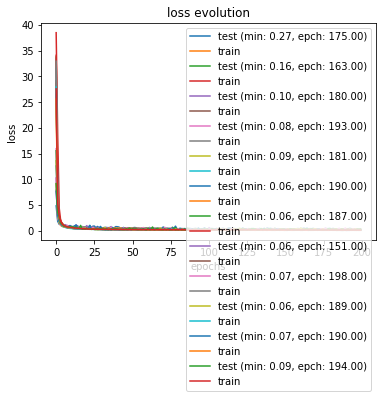

In [26]:
for idx, z_dim in enumerate(z_dims):
        
    print('========================= Model{}========================='.format(idx+1))

    # Prepare model characteristics
    name_model = 'cae_z{}_conso_temp-emb_e48-24-12_d12-24-48_gran-{}_x-{}_cond-{}'.format(z_dim,name_granu,name_type_x, name_type_cond)
    
    
    # Compile model
    model = CVAE_temp(input_dim=input_dim,
              to_emb_dim=to_emb_dim,
              cond_pre_dim=cond_pre_dim, 
              e_dims=e_dims, 
              d_dims=d_dims, 
              emb_dims=emb_dims,
              z_dim=z_dim, 
              beta=beta,
              name=name_model, 
              output=path_benchmark)

    tensorboard_model = TensorBoard(log_dir=os.path.join(path_benchmark, name_model, 'results', 'logs', time.strftime('%Y-%m-%d_%H:%M', time.localtime(time.time()))))
    tensorboard_summary = TensorBoard(log_dir=os.path.join(path_benchmark, 'logs', name_model))

    callbacks = []
    callbacks.append(tensorboard_model)
    callbacks.append(tensorboard_summary)

    # Train model
    model.main_train(dataset, training_epochs=200, batch_size=batch_size, verbose=False, callbacks=callbacks)      

    history = model.history
    best_iter = np.argmin(history['val_loss'])
    
    # result
    result = {
        'name': 'model_{}'.format(idx+1),
        'z_dim': z_dim,
        'emb_dims': emb_dims,
        'layer_dims': e_dims,
        'batchsize': batch_size,
        'best_iter': best_iter,
        'train_mse': history['loss'][best_iter],
        'test_mse': history['val_loss'][best_iter],
        'last_train_mse': history['loss'][-1],
        'last_test_mse': history['val_loss'][-1]
    }

    results_df= results_df.append(result, ignore_index=True)
    results_df.to_csv(os.path.join(path_results, 'main_results.csv'), sep=';')

    # Reset graph
    K.clear_session()
    import tensorflow as tf
    tf.reset_default_graph()


In [ ]:
model.history['recon_loss'][-1]

### Analysis of the latent space

In [26]:
name_set_plot = 'train'
version = '-v0'

In [27]:
dataset['train']['x'][2].shape

(1830, 48)

In [28]:
temp_emb = model.embedding.predict(dataset['train']['x'][2])
cond_pre = dataset['train']['x'][1]
cond = np.concatenate((cond_pre, temp_emb), axis=1)

x_input = dataset['train']['x'][0]

input_encoder = [x_input, cond]

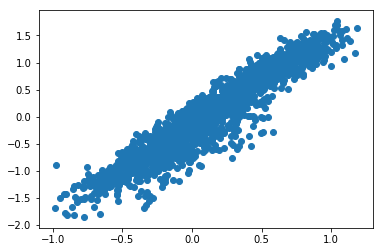

In [29]:
plt.scatter(temp_emb[:,0], temp_emb[:,1])

In [30]:
x_encoded = model.encoder.predict(input_encoder)[0]

In [31]:
# t-sne if latent space more than 2 dimension
x_encoded = TSNE(n_components=2).fit_transform(x_encoded)

In [32]:
calendar_info = pd.DataFrame(dataset[name_set_plot]['ds'])
calendar_info['month'] = calendar_info.ds.dt.month
calendar_info['weekday'] = calendar_info.ds.dt.weekday
calendar_info['is_weekday'] = (calendar_info.weekday < 5).apply(lambda x:int(x))
calendar_info = pd.merge(calendar_info, holiday_days_df[['ds', 'is_hd']], on='ds', how ='left')
calendar_info.loc[calendar_info['is_hd'].isna(),'is_hd'] = 0

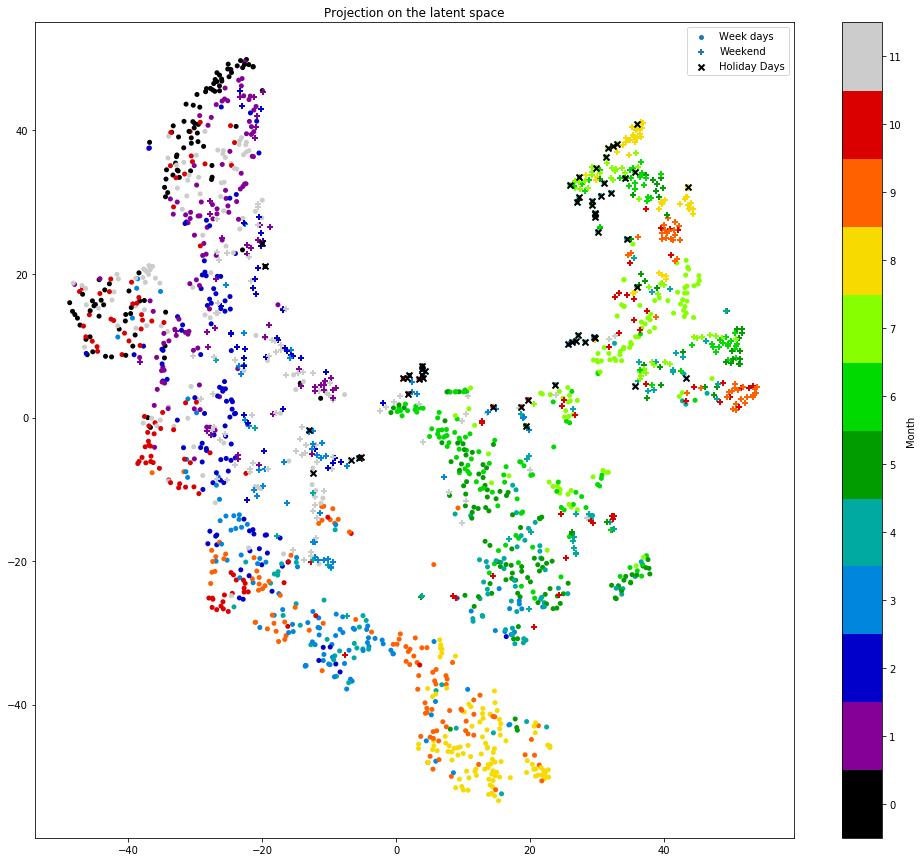

In [33]:
name_plot = 'emb{}_z{}_n-{}_beta-{}_train-{}_set-{}_cond-{}{}'.format(str(emb_dims[-1]),str(z_dim),type_scaler,str(beta), name_train, name_set_plot,str(name_type_cond),version)
plot_latent_space_projection(x_proj=x_encoded, calendar_info=calendar_info,
                             path_folder_out=os.path.join(path_out,name_model,'results'), name=name_plot, 
                             pyplot=True, plotly = False)

In [34]:
temp = get_cond_autoencoder(dataset['train']['x'],dataset['train']['ds'], type_cond=['temp'], data_conso_df=data_conso_df)
temp = temp.flatten()

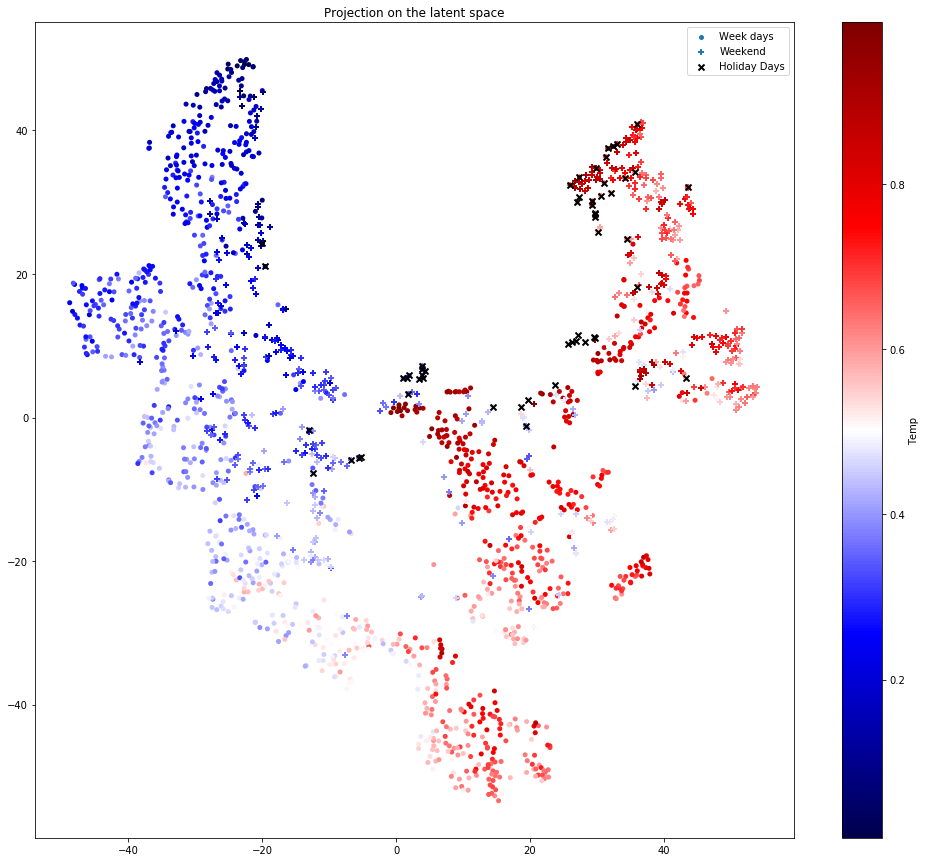

In [35]:
name_plot = 'emb{}_temp_z{}_n-{}_beta-{}_train-{}_set-{}_cond-{}{}'.format(str(emb_dims[-1]),str(z_dim),type_scaler,str(beta), name_train, name_set_plot,str(name_type_cond),version)
pyplot_latent_space_projection_temp(x_encoded, calendar_info, temp,os.path.join(path_out,name_model,'results'), name_plot)